# Tabela de Conflitos de Terra BASELENTO

#### Importar modulos

In [18]:
import pandas as pd

#### Carregar bases a partir de arquivo Excel

In [19]:
dfs = pd.read_excel('Dados/BASELEMTO_2011-2021.xlsx', sheet_name=None)

#### Selecionar a planilha de conflitos de terra (TER) do arquivo Excel

In [20]:
df = dfs['TER-2011-2021'].iloc[:, :34].copy()

display(df.head(5)); df.shape

,FichaLemto,Ficha,UF,Região,Bioma (ZT),Município,Geocódigo,Local,Local Secundário,Data,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
0,TER-2011-2021-00006,MA1301,AC,Norte,Amazonia,Acrelândia,1200013,Assent. Califórnia/Suzano Papel e Celulose,"Assent. Califórnia/Empresas CVRD, Ferro Gusa C...",2011-05-18 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Mineradora,Danos,Terra
1,TER-2011-2021-00007,MA1042,AC,Norte,Amazonia,Acrelândia,1200013,Fazenda Toca da Raposa,Fazenda Toca da Raposa,2011-12-31 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Fazendeiro,NaN,Terra
2,TER-2011-2021-00008,MA809,AC,Norte,Amazonia,Acrelândia,1200013,Correguinho/Corguinho,Correguinho/Corguinho,2011-12-31 00:00:00,...,40.0,NaN,NaN,NaN,NaN,NaN,Posseiro,Fazendeiro,Intimidação,Terra
3,TER-2011-2021-00009,AC222,AC,Norte,Amazonia,Acrelândia,1200013,Seringal Porto Luiz,Seringal Porto Luiz,2011-08-14 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Governo municipal,NaN,Terra
4,TER-2011-2021-00010,MA1668,AC,Norte,Amazonia,Acrelândia,1200013,Com. Piquiá de Baixo/Gusa Nordeste S/A/Vale,Com. Piquiá de Baixo/Gusa Nordeste S/A - CVRD/...,2011-02-16 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Mineradora,Danos,Terra


(2648, 34)

---
## Limpeza de dados

#### Remover notação especial de caracteres

In [21]:
df['Município'] = df['Município'].apply(lambda value: value.replace(' D&#39', ''))

#### Converter campo de data para formato `datetime`

In [22]:
datetime_str = df['Data'].apply(lambda value: type(value) == str)
df.loc[datetime_str, 'Data'] = pd.to_datetime(df['Data'][datetime_str], dayfirst=True, yearfirst=False)

---
## Estruturando a tabela com base em registros únicos

#### Duplicar linhas com valores múltiplos para o campo `Município`

In [23]:
def duplicate_multi_value_rows(df, col, sep=', '):
    rows = []
    for idx in df.index:
        row = df.loc[idx].copy()
        cities = row[col].split(sep)
        for city in cities:
            row[col] = city
            rows.append(dict(row))
    return pd.DataFrame(rows)


# ---
# Use a função para duplicar linhas com múltiplos valores para o campor Município

records = duplicate_multi_value_rows(df, col='Município', sep=', ')

#### Criar coluna `Ano` a partir da coluna `Data`

In [24]:
records['Ano'] = pd.DatetimeIndex(records['Data']).year

#### Reordenar colunas e linhas com base nas colunas chave

In [25]:
# Converter colunas do dataframe para lista
columns = df.columns.tolist()

# Excluir colunas chave da lista de colunas
keys = ['Município', 'Ano', 'Data']
for key in keys:
    key_index = columns.index(key)
    columns.pop(key_index)

# Adicionar colunas chaves ao início da lista de colunas
columns_reordered = keys + columns

# ---
# Reordenar colunas com base na lista de colunas

records = records[columns_reordered]

# ---
# Reordenar linhas com base nas colunas chave
records.sort_values(keys, inplace=True)

---
## Compatibilizando nomes de municípios com tabela de conflitos do CPT

#### Imprimir nomes de municípios que não estão presentes na tabela de conflitos do CPT

In [ ]:
cities_ter = records['Município'].tolist()
cities_cpt = cpt['MUN'].tolist()

# Show cities missing in secondary dataset anymore.
missing = list(set(cities_ter).difference(cities_cpt))

print('Cities missing in BASELENTO-TER dataset:\n\n', missing, '\n')

#### Renomear municípios manualmente (Compatibilizar com padrão da tabela do CPT)

In [27]:
# City renaming map
city_name_map = {
    'Diamante;Oeste': "Diamante D'Oeste",
    'Glória;Oeste': "Glória D'Oeste",
    'Pimenteiras': "Pimenteiras do Oeste",
    'Alta Floresta;Oeste': "Alta Floresta D'Oeste",
    'Alvorada;Oeste': "Alvorada D'Oeste",
    'Conquista;Oeste': "Conquista D'Oeste",
    'Nova Brasilândia;Oeste': "Nova Brasilândia D'Oeste",
    'Sant&#39;Ana do Livramento': "Sant'Ana do Livramento",    
}


# ---
# Rename cities to match CPT standard

for name, new_name in city_name_map.items():
    records.loc[records['Município'] == name, 'Município'] = new_name

#### Conferir se restaram nomes de municípios que não estão presentes na tabela de conflitos do CPT

In [ ]:
cities_ter = records['Município'].tolist()
cities_cpt = cpt['MUN'].tolist()

# Show that there are no cities missing in secondary dataset anymore.
missing = list(set(cities_ter).difference(cities_cpt))

print('Cities missing after city name formatting:\n\n', missing)

---
### Salvar tabela limpa

In [28]:
clean_path = 'Resultados/baselento-ter'

records.to_excel(clean_path + '.xlsx', index=False)
# records.to_csv(clean_path + '.csv', index=False)

print('Dataframes saved')
display(records.head())
print(records.shape)

Dataframes saved


,Município,Ano,Data,FichaLemto,Ficha,UF,Região,Bioma (ZT),Geocódigo,Local,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
3553,Abelardo Luz,2011,2011-06-06,TER-2011-2021-00001,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,Ameaça de Morte,Terra
3562,Abelardo Luz,2012,2012-02-28,TER-2011-2021-01643,AP143,SC,Sul,Mata Atlantica,4219507,Fazenda Santa Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário Internacional,Intimidação,Terra
3554,Abelardo Luz,2012,2012-06-21,TER-2011-2021-00821,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra
3558,Abelardo Luz,2012,2012-06-30,TER-2011-2021-01642,AP144,SC,Sul,Mata Atlantica,4219507,Ponta do Socorro e Vareiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário,Intimidação,Terra
3555,Abelardo Luz,2012,2012-07-17,TER-2011-2021-00822,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra


(3620, 34)


---
## Construção de série anual de conflitos de terra por cidade (BASELENTO-TER)

In [29]:
import pandas as pd

#### Recarregar tabela de registros de conflitos de terra da BASELENTO-TER

In [30]:
records = pd.read_excel('Resultados/baselento-ter.xlsx')

records.shape

(3620, 34)

#### Criar coluna chave `id_municipio` representando conjunto unico de cidade / estado

In [31]:
names = records['Município'].str.strip().str.lower()
states = records['UF'].str.strip().str.lower()

records['id_municipio'] = names + ' - ' + states

#### Contar conflitos por cidade e ano

In [32]:
count = records.groupby(['id_municipio', 'Ano']).apply(len).unstack().fillna(0)

#### Converter tabela para tipo de dado inteiro

In [33]:
count = count.astype(int)

### Salvar tabela com séries anuais por cidade

In [34]:
count.to_excel('Resultados/baselento-ter-anual.xlsx', index=True)
# count.to_csv('Resultados/baselento-ter-anual.csv', index=True)

print('Dataframes saved')
display(count.head())
print(count.shape)

Dataframes saved


Ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
id_municipio,,,,,,,,,,,
abelardo luz - sc,1,4,1,3,1,1,1,1,0,5,0
acrelândia - ac,8,11,5,4,3,11,6,5,3,15,15
alenquer - pa,0,0,0,0,2,3,1,0,1,2,1
almeirim - pa,0,0,1,2,2,1,0,0,0,0,0
alpestre - rs,0,0,0,0,0,0,0,0,0,0,2


(239, 11)


---
## Extra: Visualizar séries anuais de conflito de terra por cidades da BASELENTO-TER

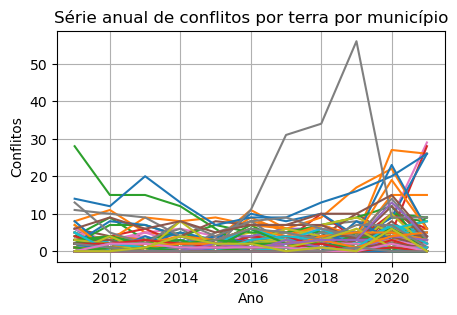

In [35]:
ax = count.T.plot(
    title='Série anual de conflitos por terra por município',
    ylabel='Conflitos',
    figsize=(5, 3),
    grid=True,
    legend=[],
)